In [1]:
# argo/ecco comparisons 

In [178]:
import numpy as np
import sys
import gsw
import glob 
import datetime as dt
from datetime import datetime 
import pandas as pd
import xarray as xr
import numpy as np
from scipy import integrate
import scipy.interpolate as si
from copy import deepcopy 
import matplotlib.pyplot as plt
%matplotlib inline
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib as mpl
from xgcm import Grid 
import warnings
warnings.filterwarnings('ignore')
sys.path.append('/Users/jakesteinberg/ECCOv4-py/ECCOv4-py')
import ecco_v4_py as ecco

In [121]:
# -- ECCO GRIDS -- 
# base_dir = '/home/username/'
base_dir = '/Users/jakesteinberg/Documents/NASA_OSTST/ECCO/'
## define a high-level directory for ECCO fields
ECCO_dir = base_dir + '/v5'
## Load the model grid
grid_dir= ECCO_dir + '/nctiles_grid/'
# ecco_grid = ecco.load_ecco_grid_nc(grid_dir, 'ECCOv4r3_grid.nc', k_subset=[0])
ecco_grid = ecco.load_ecco_grid_nc(grid_dir, 'ECCO-GRID.nc')

# bathymetry
tile_num=10
lon_range = [-98, -78]; lat_range = [17, 31] 
lons = ecco_grid.XC.sel(tile=tile_num)
lats = ecco_grid.YC.sel(tile=tile_num)
dep = ecco_grid.Depth
dep = dep.where(ecco_grid.hFacC.isel(tile=tile_num,k=0) !=0, np.nan).isel(tile=tile_num)

In [142]:
files = glob.glob('/Users/jakesteinberg/Documents/NASA_OSTST/ECCO/v5/profiles/argo*.nc')
files = np.sort(files)
# filename_0 = '/Users/jakesteinberg/Documents/NASA_OSTST/ECCO/v5/profiles/argo_2008_feb2016_llc270_step_01_20160308_model.nc'
# filename_0 = '/Users/jakesteinberg/Documents/NASA_OSTST/ECCO/v5/profiles/argo_2012_feb2016_llc270_step_01_20160308_model.nc'
# filename_1 = '/Users/jakesteinberg/Documents/NASA_OSTST/ECCO/v5/profiles/argo_2016_Feb2018_llc270_model.nc'
# filename_2 = '/Users/jakesteinberg/Documents/NASA_OSTST/ECCO/v5/profiles/argo_2017_Feb2018_llc270_model.nc'
profiles_0 = xr.open_dataset(files[2]); 
profiles_1 = xr.open_dataset(files[-1]);
# files = [filename_0,filename_1,filename_2]

In [308]:
profiles.prof_depth[24:35]

<xarray.DataArray 'prof_depth' (iDEPTH: 11)>
array([300., 320., 340., 360., 380., 400., 420., 440., 460., 480., 500.])
Dimensions without coordinates: iDEPTH
Attributes:
    long_name:  depth
    units:      me

In [309]:
lon_range = [-98,-81]; lat_range = [18,31];
p_i = []; pbias = []; pbias_shallow = []; pbias_deep = []; ptime = [];
for i in range(len(files)):
    profiles = xr.open_dataset(files[i]);
    # profile indices 
    p0 = np.where((profiles.prof_lon > lon_range[0]) & (profiles.prof_lon < lon_range[-1]) & \
                   (profiles.prof_lat > lat_range[0]) & (profiles.prof_lat < lat_range[-1]))[0]
    p_i.append(p0)
    # -- temperature profile bias -- 
    pbias_i = np.nan*np.ones((len(p0),len(profiles.prof_depth)))
    for j in range(len(p0)): 
        pbias_i[j,:] = profiles.prof_T[p0[j],:] - profiles.prof_Testim[p0[j],:]
    pbias.append(np.nanmean(pbias_i,axis=1)) # average temp anomaly over depths
    pbias_shallow.append(np.nanmean(pbias_i[:,0:10],axis=1)) 
    pbias_deep.append(np.nanmean(pbias_i[:,24:35],axis=1)) 
    # -- warming trend -- 
    ptime_i = []
    for j in range(len(p0)):
        ptime_i.append(datetime.fromordinal(int(profiles.prof_date[p0][j].data)) + \
                       dt.timedelta(days=profiles.prof_date[p0][j].data%1) - dt.timedelta(days=366))
    ptime.append(ptime_i)

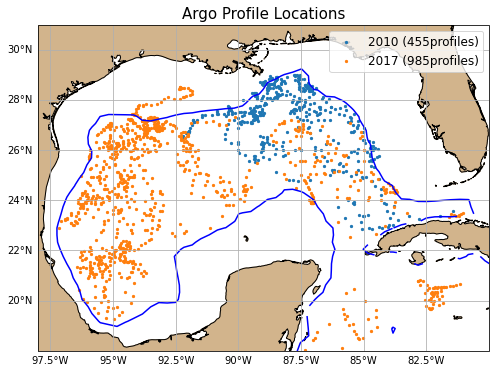

In [144]:
f, ax = plt.subplots(1,1,figsize=(10,6), subplot_kw={'projection':ccrs.PlateCarree(central_longitude=0)})
ax.scatter(profiles_0.prof_lon[p_i[2]],profiles_0.prof_lat[p_i[2]],s=5,label='2010 (' + str(len(p_i[2])) + 'profiles)')
ax.scatter(profiles_1.prof_lon[p_i[-1]],profiles_1.prof_lat[p_i[-1]],s=5,label='2017 (' + str(len(p_i[-1])) + 'profiles)')
ax.contour(lons,lats,dep,levels=[1000],colors='b')
ax.add_feature(cartopy.feature.LAND, color='#D2B48C',zorder=1); ax.coastlines()
gl = ax.gridlines(draw_labels=True); gl.xlabels_top = False; gl.ylabels_right = False;
ax.set_xlim([-98,-80]); ax.set_ylim([18,31]);
ax.set_title('Argo Profile Locations',fontsize=15)
ax.grid(); ax.legend(fontsize=12)

In [54]:
# -- load RG gridded Argo -- 
filename = ('/Users/jakesteinberg/Documents/NASA_OSTST/Argo_RG/rho_0_2000m.nc')
argo_rho = xr.open_dataset(filename)
RGdensity = argo_rho.__xarray_dataarray_variable__
RGlon = argo_rho.longitude
RGlat = argo_rho.latitude

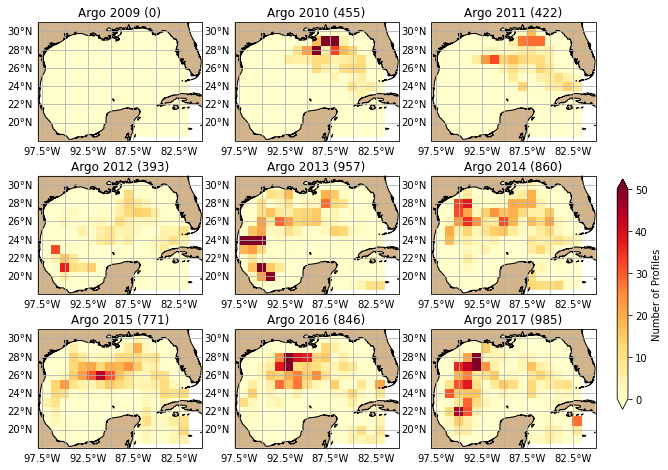

In [302]:
f, ax = plt.subplots(3,3,figsize=(10,8), subplot_kw={'projection':ccrs.PlateCarree(central_longitude=0)})
Ax = ax.flatten()
pden = np.nan*np.ones((len(files), len(RGlat), len(RGlon))); count = 0
for i in range(1,10):
    profiles = xr.open_dataset(files[i]);
    for j in range(len(RGlat)):
        for k in range(len(RGlon)):
            pin = np.where((profiles.prof_lon[p_i[i]] > (RGlon[k]-0.5)) & (profiles.prof_lon[p_i[i]] < (RGlon[k]+0.5)) & \
                     (profiles.prof_lat[p_i[i]] > (RGlat[j]-0.5)) & (profiles.prof_lat[p_i[i]] < (RGlat[j]+0.5)))[0]
            pden[i,j,k] = len(pin)
    pp = Ax[count].pcolor(RGlon,RGlat,pden[i],vmin=0,vmax=50,cmap='YlOrRd')
    Ax[count].add_feature(cartopy.feature.LAND, color='#D2B48C',zorder=1); Ax[count].coastlines()
    gl = Ax[count].gridlines(draw_labels=True); gl.xlabels_top = False; gl.ylabels_right = False;
    Ax[count].set_xlim([-98,-80]); Ax[count].set_ylim([18,31]);
    Ax[count].set_title('Argo ' + files[i][64:68] + ' (' + str(len(p_i[i])) + ')',fontsize=12)
    Ax[count].grid()
    count = count+1
cbpos = [0.93, 0.2, 0.015, 0.4]; cax = f.add_axes(cbpos); 
cb = f.colorbar(pp, cax=cax, orientation='vertical', extend='both', label=r'Number of Profiles')
f.savefig('/Users/jakesteinberg/Documents/NASA_OSTST/meetings/2022_04_20/GOM_argo_profiles.jpg', dpi=250)

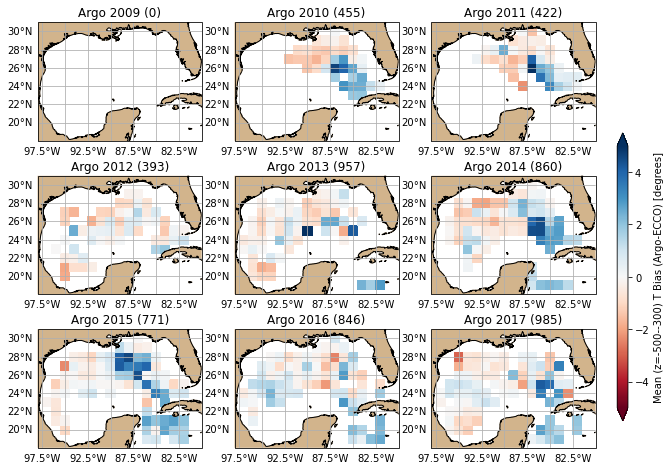

In [313]:
f, ax = plt.subplots(3,3,figsize=(10,8), subplot_kw={'projection':ccrs.PlateCarree(central_longitude=0)})
Ax = ax.flatten()
pbi = np.nan*np.ones((len(files), len(RGlat), len(RGlon))); count = 0;
for i in range(1,10):
    profiles = xr.open_dataset(files[i]);
    for j in range(len(RGlat)):
        for k in range(len(RGlon)):
            pin = np.where((profiles.prof_lon[p_i[i]] > (RGlon[k]-0.5)) & (profiles.prof_lon[p_i[i]] < (RGlon[k]+0.5)) & \
                     (profiles.prof_lat[p_i[i]] > (RGlat[j]-0.5)) & (profiles.prof_lat[p_i[i]] < (RGlat[j]+0.5)))[0]
            pbi[i,j,k] = np.nanmean(pbias_deep[i][pin])
    
    pp = Ax[count].pcolor(RGlon,RGlat,pbi[i],vmin=-5,vmax=5,cmap='RdBu')
    Ax[count].add_feature(cartopy.feature.LAND, color='#D2B48C',zorder=1); Ax[count].coastlines()
    gl = Ax[count].gridlines(draw_labels=True); gl.xlabels_top = False; gl.ylabels_right = False;
    Ax[count].set_xlim([-98,-80]); Ax[count].set_ylim([18,31]);
    Ax[count].set_title('Argo ' + files[i][64:68] + ' (' + str(len(p_i[i])) + ')',fontsize=12)
    Ax[count].grid()
    count = count+1
cbpos = [0.93, 0.18, 0.015, 0.5]; cax = f.add_axes(cbpos); 
cb = f.colorbar(pp, cax=cax, orientation='vertical', extend='both', label=r'Mean (z=-500--300) T Bias (Argo-ECCO) [degrees]')
f.savefig('/Users/jakesteinberg/Documents/NASA_OSTST/meetings/2022_04_20/GOM_argo_ecco_t_bias_lower.jpg', dpi=250)

In [272]:
# place all profiles into one array 
Time_tot = []
for i in range(2,len(files)):
    profiles = xr.open_dataset(files[i]);
    if i > 2:
        Temp_tot = np.concatenate((Temp_tot,profiles.prof_T[p_i[i]].data),axis=0)
        TempE_tot = np.concatenate((TempE_tot,profiles.prof_Testim[p_i[i]].data),axis=0)
        Lon_tot = np.concatenate((Lon_tot,profiles.prof_lon[p_i[i]].data),axis=0)
        Lat_tot = np.concatenate((Lat_tot,profiles.prof_lat[p_i[i]].data),axis=0)
        Time_tot = np.concatenate((Time_tot,profiles.prof_date[p_i[i]].data))
    else:
        Temp_tot = profiles.prof_T[p_i[i]].data
        TempE_tot = profiles.prof_Testim[p_i[i]].data
        Lon_tot = profiles.prof_lon[p_i[i]].data
        Lat_tot = profiles.prof_lat[p_i[i]].data
        Time_tot = profiles.prof_date[p_i[i]].data
        

In [271]:
ptimes[2].timestamp()

1396172556.0

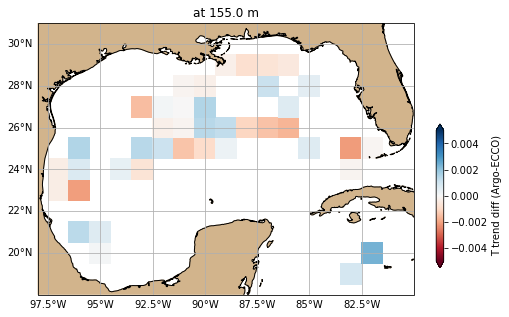

In [327]:
trend_dep = 15
f, ax = plt.subplots(1,1,figsize=(7,5), subplot_kw={'projection':ccrs.PlateCarree(central_longitude=0)})
pbi = np.nan*np.ones((len(files), len(RGlat), len(RGlon))); 
ptrenddiff = np.nan*np.ones((len(RGlat),len(RGlon)))
for j in range(len(RGlat)):
    for k in range(len(RGlon)):
        pin = np.where((Lon_tot > (RGlon[k].data-0.5)) & (Lon_tot < (RGlon[k].data+0.5)) & \
                       (Lat_tot > (RGlat[j].data-0.5)) & (Lat_tot < (RGlat[j].data+0.5)))[0]
        if len(pin) > 20: 
            ptimes = Time_tot[pin]
            t_ord = np.argsort(ptimes)
            ptemps = Temp_tot[pin[t_ord],:]
            ptempsECCO = TempE_tot[pin[t_ord],:]
            
            ptime_i = []
            for l in range(len(ptimes)):
                ptime_i.append(datetime.fromordinal(int(ptimes[t_ord[l]])) + \
                               dt.timedelta(days=ptimes[t_ord[l]]%1) - dt.timedelta(days=366))
            
            Atrend = np.polyfit(ptimes, ptemps[:,trend_dep], deg=1)
            Etrend = np.polyfit(ptimes, ptempsECCO[:,trend_dep], deg=1)
            ptrenddiff[j,k] = Atrend[0] - Etrend[0]
            
pp = ax.pcolor(RGlon,RGlat,ptrenddiff,vmin=-0.005,vmax=.005,cmap='RdBu')
ax.add_feature(cartopy.feature.LAND, color='#D2B48C',zorder=1); ax.coastlines()
gl = ax.gridlines(draw_labels=True); gl.xlabels_top = False; gl.ylabels_right = False;
ax.set_title('at '+ str(profiles.prof_depth[trend_dep].data) + ' m')
ax.set_xlim([-98,-80]); ax.set_ylim([18,31]);
ax.grid()
cbpos = [0.93, 0.2, 0.015, 0.4]; cax = f.add_axes(cbpos); 
cb = f.colorbar(pp, cax=cax, orientation='vertical', extend='both', label=r'T trend diff (Argo-ECCO)')

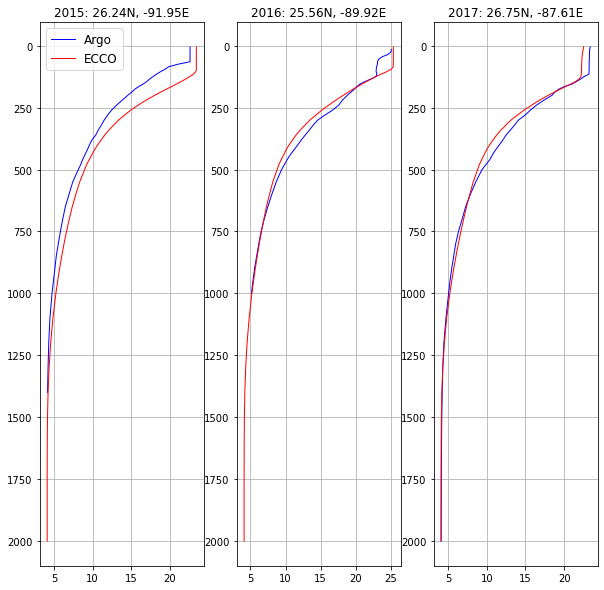

In [325]:
f, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(10,10))
i = 7; p = 0; 
profiles = xr.open_dataset(files[i]);
ax1.plot(profiles.prof_T[p_i[i][p],:], profiles.prof_depth, color='b', linewidth=1, label='Argo')
ax1.plot(profiles.prof_Testim[p_i[i][p],:], profiles.prof_depth, color='r', linewidth=1, label='ECCO')
ax1.set_title(files[i][64:68] + ': ' + str(np.round(profiles.prof_lat[p_i[i][p]].data,2)) + \
              'N, ' + str(np.round(profiles.prof_lon[p_i[i][p]].data,2)) + 'E')
i = 8; p = 20;
profiles = xr.open_dataset(files[i]);
ax2.plot(profiles.prof_T[p_i[i][p],:], profiles.prof_depth, color='b', linewidth=1, label='Argo')
ax2.plot(profiles.prof_Testim[p_i[i][p],:], profiles.prof_depth, color='r', linewidth=1, label='ECCO')
ax2.set_title(files[i][64:68] + ': ' + str(np.round(profiles.prof_lat[p_i[i][p]].data,2)) + \
              'N, ' + str(np.round(profiles.prof_lon[p_i[i][p]].data,2)) + 'E')
i = 9; p = 200;
profiles = xr.open_dataset(files[i]);
ax3.plot(profiles.prof_T[p_i[i][p],:], profiles.prof_depth, color='b', linewidth=1, label='Argo')
ax3.plot(profiles.prof_Testim[p_i[i][p],:], profiles.prof_depth, color='r', linewidth=1, label='ECCO')
ax3.set_title(files[i][64:68] + ': ' + str(np.round(profiles.prof_lat[p_i[i][p]].data,2)) + \
              'N, ' + str(np.round(profiles.prof_lon[p_i[i][p]].data,2)) + 'E')
ax1.invert_yaxis(); ax1.grid(); ax1.legend(fontsize=12)
ax2.invert_yaxis(); ax2.grid(); 
ax3.invert_yaxis(); ax3.grid(); 